In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

df = pd.read_csv('./data/bbb.csv', sep=';')
df = df[df['Objects'].str.contains('_c0')]
df['Objects'] = df['Objects'].str.replace('_c0', '')
df_label = pd.read_csv('./data/bbb_label.csv', sep=' ', header=None)
# give a name to the columns 
df_label.columns = ['Objects', 'label']
# select only row with the same name as in the label file
df = df[df['Objects'].isin(df_label['Objects'])]
df = df.set_index('Objects')
df_label = df_label.set_index('Objects')
# add all in a single dataframe
df = df.join(df_label)
print(df.head())

                V        S        R        G        W1       W2       W3  \
Objects                                                                    
MOL_0001  747.125  482.581  1.54819  1.33424  1098.380  579.750  272.750   
MOL_0002  952.125  637.029  1.49463  1.58788  1294.120  597.500  262.625   
MOL_0004  549.625  368.758  1.49047  1.21149   798.000  324.500  105.500   
MOL_0009  595.750  414.276  1.43805  1.33090   898.375  406.875  210.125   
MOL_0012  448.500  316.026  1.41919  1.17786   692.250  323.000  145.625   

               W4      W5      W6  ...     L4LgS     DD1     DD2    DD3  \
Objects                            ...                                    
MOL_0001  106.375  48.875  13.875  ... -0.067867  61.750  32.500  15.75   
MOL_0002  104.625  54.875  29.750  ... -0.137969  92.875  37.500  20.25   
MOL_0004   35.875  15.500   6.625  ...  0.012077   0.000   0.000   0.00   
MOL_0009   98.000  51.625  25.125  ... -0.315401  30.500  20.125  11.50   
MOL_0012   63.000

In [2]:
X = df.drop('label', axis=1)
X = X.fillna(0)
y = df['label']
print(X.shape)
CORRCUT = 0.95
# remove highly correlated features 
corr_matrix = X.corr().abs()
#print(np.triu(np.ones(corr_matrix.shape), \
#                                  k=1).astype(np.bool))
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), \
                                  k=1).astype(bool))
#print(upper)
to_drop = [column for column in upper.columns if any(upper[column] > CORRCUT)]
#for i in to_drop:
#    print(f"Removing {i} because of high correlation")
X = X.drop(X[to_drop], axis=1)
print(X.shape)

(2103, 128)
(2103, 68)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                    test_size=0.2, random_state=42)
accuracys = []
numoftrees = []
for numofest in range(1, 100, 10):
    rf = RandomForestClassifier(n_estimators=numofest, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracys.append(acc)
    numoftrees.append(numofest)
    #print(f"Accuracy for {numofest} trees:", accuracy)

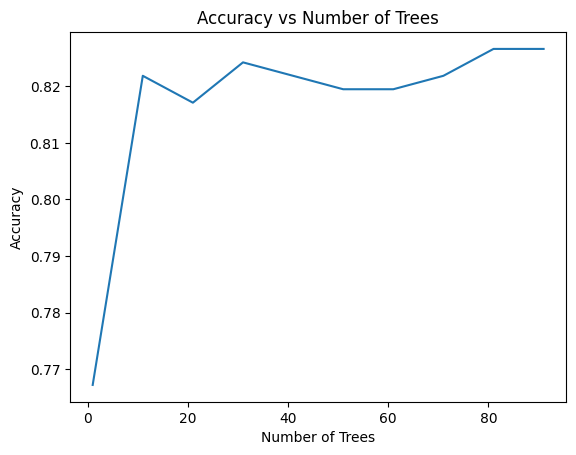

Max Accuracy: 0.8266033254156769
Number of Trees: 81


In [4]:
# plot saccuracy vs number of trees
import matplotlib.pyplot as plt
plt.plot(numoftrees, accuracys)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Trees')
plt.show()
print("Max Accuracy:", max(accuracys))
bestnoftrees = numoftrees[accuracys.index(max(accuracys))]
print("Number of Trees:", bestnoftrees)

In [5]:
# build model with best number of trees
rf = RandomForestClassifier(n_estimators=bestnoftrees, \
                            random_state=42)
rf.fit(X_train, y_train)
# print out the max detpth used in the trees
print("Max Depth:", rf.max_depth)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
# the same for the training set 
y_pred_train = rf.predict(X_train)
print("Accuracy on training set:", \
      accuracy_score(y_train, y_pred_train))
print("Confusion Matrix on training set:")
print(confusion_matrix(y_train, y_pred_train))
print("Precision on training set:", \
      precision_score(y_train, y_pred_train))
print("Recall on training set:", \
      recall_score(y_train, y_pred_train))

Max Depth: None
Accuracy: 0.8266033254156769
Confusion Matrix:
[[ 42  59]
 [ 14 306]]
Precision: 0.8383561643835616
Recall: 0.95625
Accuracy on training set: 1.0
Confusion Matrix on training set:
[[ 358    0]
 [   0 1324]]
Precision on training set: 1.0
Recall on training set: 1.0


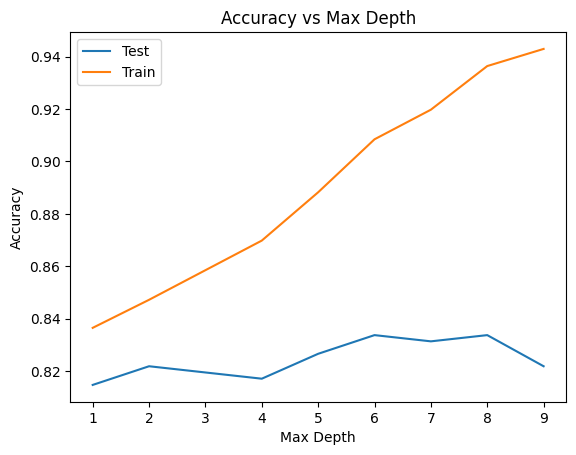

Max Accuracy: 0.833729216152019 Max Depth: 6


In [6]:
testaccuracy = []
trainaccuracy = []
for maxdepth in range(1, 10):
    # Maybe you want to use a validation set to find the best max depth
    # and other hyperparameters instead of using the test set
    rf = RandomForestClassifier(n_estimators=bestnoftrees, \
                            max_depth=maxdepth, \
                            random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    testaccuracy.append(accuracy_score(y_test, y_pred))
    y_pred_train = rf.predict(X_train)
    trainaccuracy.append(accuracy_score(y_train, y_pred_train))

plt.plot(range(1, 10), testaccuracy, label='Test')
plt.plot(range(1, 10), trainaccuracy, label='Train')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.show()
bestdepth = testaccuracy.index(max(testaccuracy))+1
print ("Max Accuracy:", max(testaccuracy),\
        "Max Depth:", bestdepth)

In [7]:
rf = RandomForestClassifier(n_estimators=bestnoftrees, \
                            max_depth=bestdepth, \
                            random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
# the same for the training set
y_pred_train = rf.predict(X_train)
print("Accuracy on training set:", \
      accuracy_score(y_train, y_pred_train))
print("Confusion Matrix on training set:")
print(confusion_matrix(y_train, y_pred_train))
print("Precision on training set:", \
      precision_score(y_train, y_pred_train))
print("Recall on training set:", \
        recall_score(y_train, y_pred_train))


Accuracy: 0.833729216152019
Confusion Matrix:
[[ 37  64]
 [  6 314]]
Precision: 0.8306878306878307
Recall: 0.98125
Accuracy on training set: 0.9084423305588585
Confusion Matrix on training set:
[[ 205  153]
 [   1 1323]]
Precision on training set: 0.8963414634146342
Recall on training set: 0.9992447129909365


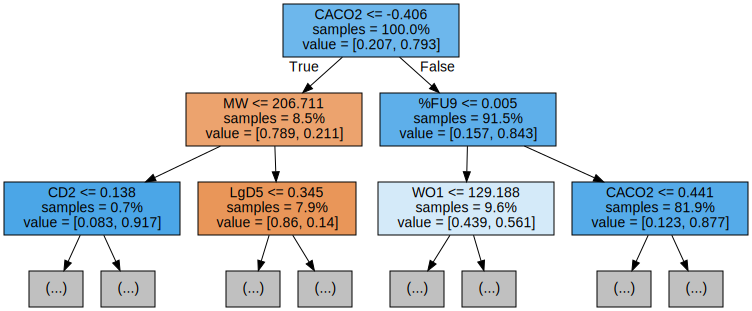

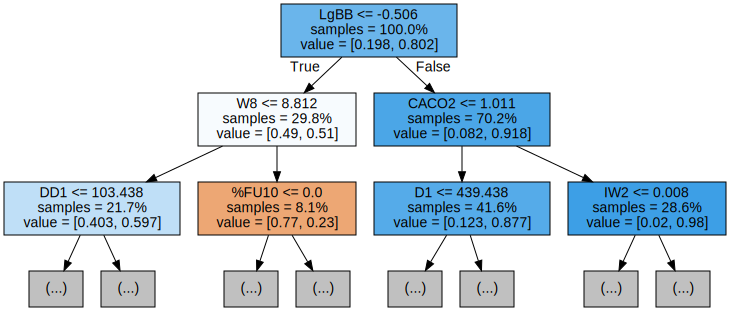

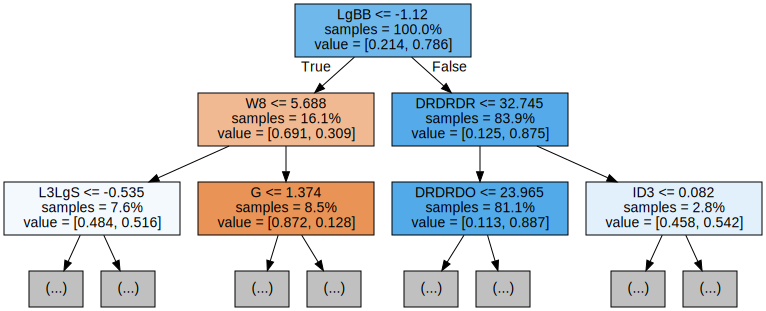

In [8]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [9]:
# drop logbb from the columns
X = X.drop('LgBB', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                    test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=bestnoftrees, \
                            max_depth=bestdepth, \
                            random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
# the same for the training set
y_pred_train = rf.predict(X_train)
print("Accuracy on training set:", \
      accuracy_score(y_train, y_pred_train))
print("Confusion Matrix on training set:")
print(confusion_matrix(y_train, y_pred_train))
print("Precision on training set:", \
      precision_score(y_train, y_pred_train))
print("Recall on training set:", \
        recall_score(y_train, y_pred_train))


Accuracy: 0.828978622327791
Confusion Matrix:
[[ 35  66]
 [  6 314]]
Precision: 0.8263157894736842
Recall: 0.98125
Accuracy on training set: 0.9054696789536266
Confusion Matrix on training set:
[[ 200  158]
 [   1 1323]]
Precision on training set: 0.8933153274814315
Recall on training set: 0.9992447129909365


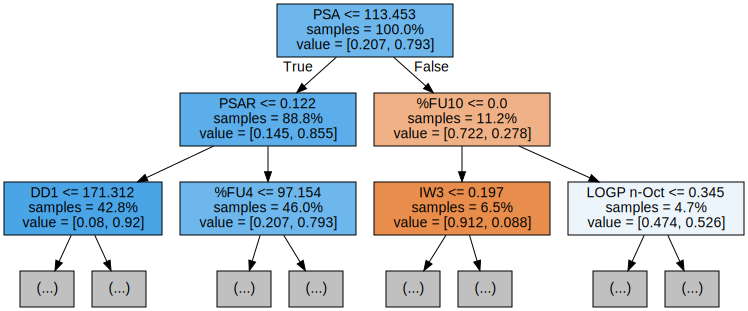

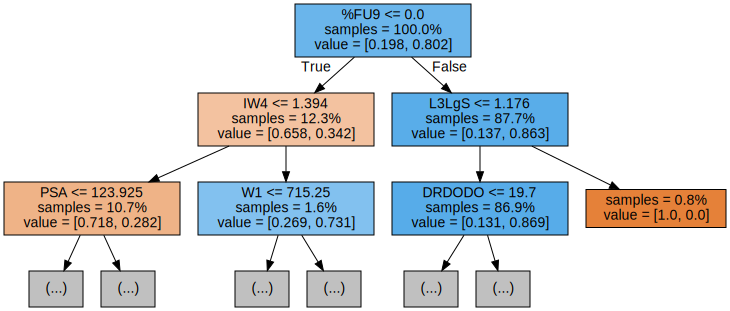

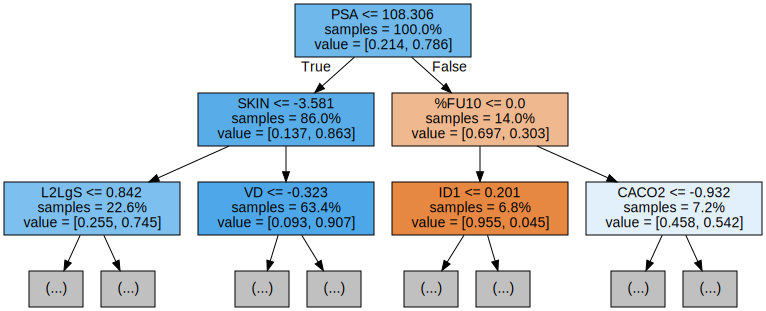

In [10]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

/home/redo/anaconda3/envs/lastpy/lib/python3.14/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


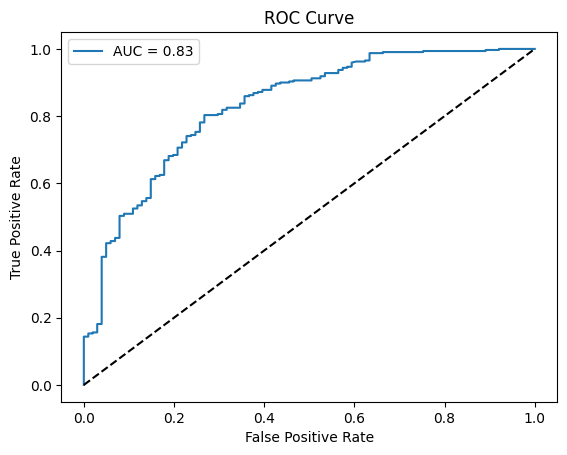

AUC: 0.8316676980198021


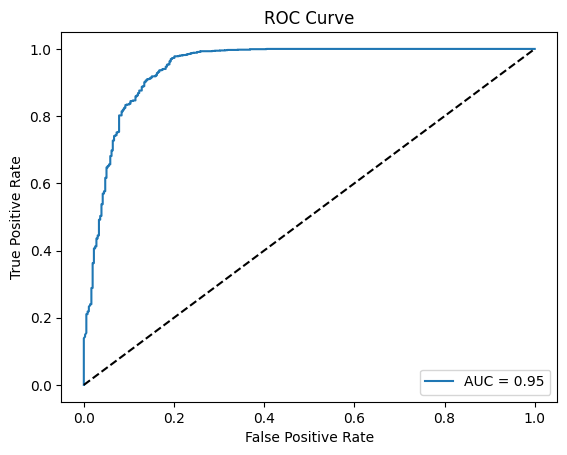

AUC on training set: 0.9461066853449004


In [11]:
# build the roc curve using a RF regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)
rf = RandomForestRegressor(n_estimators=bestnoftrees, \
                            max_depth=bestdepth, \
                            random_state=42)
rf.fit(X_train, y_train_bin)
y_pred = rf.predict(X_test)
#print(y_pred)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print("AUC:", roc_auc_score(y_test_bin, y_pred))

# the same for the training set
y_pred_train = rf.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train_bin, y_pred_train)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print("AUC on training set:", roc_auc_score(y_train_bin, y_pred_train))
